<a href="https://colab.research.google.com/github/MelikaKalbasi/knowledge-discovery/blob/main/HW1MelikaKalbasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib==3.5 #with newer versions of matplotlib this notebook might not run
%matplotlib inline
!pip install captum==0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pytorch-gradcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 67.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5246 sha256=178ad33823613bee4e0ce6e28964f62c439bb312a2a30ac26f249be242652830
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 24.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import cv2
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.nn import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.ops.boxes import box_iou
from torchvision.transforms.functional import to_pil_image, to_tensor
import torch.nn.functional as F
from torchvision.transforms.functional import resize
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms as torchtrans  
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from numpy import asarray
import torchmetrics
from torchmetrics.classification import Accuracy
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dset_dir = "/content/drive/MyDrive/AI/" 
os.listdir(dset_dir)

['test.csv', 'submission.csv', 'train.csv', 'test', 'train']

In [ ]:
import torch.nn.functional as F
from torch.nn import Conv2d
class UnictImg(Dataset):
    def __init__(self, dset_dir, train=True,mask=False,res_bb_perc=0, transforms=None):
        
        self.split = "train" if train else "test"
        self.dset_dir = Path(dset_dir)/self.split
        self.transforms = transforms
        self.res_bb_perc=res_bb_perc
        self.mask=mask
        self.files = []
        self.df_bb=pd.DataFrame()
        self.df_bb=pd.read_csv(dset_dir+"train.csv")
        folders = sorted(os.listdir(self.dset_dir))
        self.file=folders
        if self.split=="train" :         
            for folder in folders:
                class_idx= folders.index(folder)
                folder_dir = self.dset_dir/folder
                files = os.listdir(folder_dir)
                if(class_idx==0):
                    self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":True} for x in files]
                else:
                    self.files+=[{"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":False} for x in files]
        else:
            self.files+=[self.dset_dir/file for file in folders]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        
        if self.split == "train":
            
            item = self.files[i]
            file = item['file']
            # reading the images and converting them to correct size and color    
            img = cv2.imread(str(file))
            img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            # diving by 255
            img_res /= 255.0
            
            # recover bounding boxes
            name_file_img=item['mask']
            bb=self.df_bb[self.df_bb["image"]==name_file_img]
          
            # resize bounding boxes
            xmin=int(bb["x1"])+1
            ymin=int(bb["y1"])+1
            xmax=int(bb["x2"])-1
            ymax=int(bb["y2"])-1
            res_bb_perc=self.res_bb_perc
            boxes = [[xmin+((xmax-xmin)*res_bb_perc), 
                      ymin+((ymax-ymin)*res_bb_perc), 
                      xmax-((xmax-xmin)*res_bb_perc), 
                      ymax-((ymax-ymin)*res_bb_perc)]]           
           
                    
            labels = torch.tensor(item['class'],dtype=torch.int64)
            labels=labels.unsqueeze(0)
                                    
            # applying transformations            
            sample = {'image' : img_res,
                      'bboxes' : boxes,
                      'labels' : labels}
               
            sample = self.transforms(**sample)
            target = {}
            target["boxes"] =torch.tensor(sample['bboxes'],dtype=torch.int64)
            target["labels"] = torch.tensor(sample['labels'],dtype=torch.int64)
            img_res = sample['image']
            
            if(self.mask and item['flag']):
                
                bb=target['boxes'][0]
                #creating masked image
                mask=torch.zeros(3,224,224)
                mask[0:3,bb[1]:bb[3],bb[0]:bb[2]]
                img_masked=torch.mul(img_res,mask)
                #setting random colors to apply to RGB channels
                r=np.random.random()
                g=np.random.random()
                b=np.random.random()
                # adding random colors to black pixel to avoid bias
                img_masked[0]+=r
                img_masked[0,bb[1]:bb[3],bb[0]:bb[2]]-=r
                img_masked[1]+=g
                img_masked[1,bb[1]:bb[3],bb[0]:bb[2]]-=g
                img_masked[2]+=b
                img_masked[0,bb[1]:bb[3],bb[0]:bb[2]]-=b
                
            return img_res, target 
               
        else:
            file = self.files[i]
            # reading the images and converting them to correct size and color    
            img = cv2.imread(str(file))
            img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            # diving by 255
            img_res /= 255.0
            
            sample = {'image': img_res}
            sample = self.transforms(**sample)
            image = sample['image']
           
            return image,self.file[i]

In [ ]:
# Define the transforms
#data augmentation
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(shift_limit=0.2,scale_limit=0.2, rotate_limit=0, p=0.7),        
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [ ]:
# Define the data loader
def collate_fn(batch):
    return tuple(zip(*batch))
train_dataset = UnictImg(dset_dir, train=True,res_bb_perc=0.1,transforms= get_train_transform())
test_dataset = UnictImg(dset_dir, train=False, transforms= get_test_transform())
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 9 # 8 Classes + 1 background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 297MB/s]


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Define the optimizer
import torch.optim as optim
# Define the optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0001)
lr_scheduler =torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)

In [ ]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
num_epochs = 7
loss_hist = Averager()
itr = 1
loss_history_iter = []
loss_history_epoch = []


for epoch in range(num_epochs):
    loss_hist.reset()
    model.train()
    for images, targets in train_data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        # Forward pass with activations
        loss_dict = model(images, targets) 
        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()
        loss_hist.send(loss_value)
        loss_history_iter.append(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")
        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    loss_history_epoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")






Iteration #50 loss: 0.30846941471099854
Iteration #100 loss: 0.21458737552165985
Epoch #0 loss: 0.29764445349574087
Iteration #150 loss: 0.20075178146362305
Iteration #200 loss: 0.14977887272834778
Epoch #1 loss: 0.20395783066749573
Iteration #250 loss: 0.16723261773586273
Iteration #300 loss: 0.13637875020503998
Epoch #2 loss: 0.1494687895476818
Iteration #350 loss: 0.12214880436658859
Iteration #400 loss: 0.1799243688583374
Epoch #3 loss: 0.14583578296005725
Iteration #450 loss: 0.1494738906621933
Iteration #500 loss: 0.1103036180138588
Epoch #4 loss: 0.1279742879420519
Iteration #550 loss: 0.10100028663873672
Iteration #600 loss: 0.10916031897068024
Epoch #5 loss: 0.1171265882998705
Iteration #650 loss: 0.09415031224489212
Iteration #700 loss: 0.09807705134153366
Epoch #6 loss: 0.11374110281467438


In [ ]:
img_list=[]
class_list=[]
for idx in range(test_dataset.__len__()):
    img,name_file = test_dataset[idx]

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    nms_prediction = apply_nms(prediction, iou_thresh=0.5)
    pred=nms_prediction['labels'].cpu().numpy()[0]
    
    img_list.append(name_file)
    class_list.append(pred-1)
    
import pandas as pd

d = {'image': img_list, 'class': class_list}
df = pd.DataFrame(data=d)
df.to_csv("Submission.csv",index=False)

In [ ]:
from captum.attr import GuidedGradCam, NoiseTunnel
from captum.attr import visualization as viz, LayerGradCam, LayerAttribution
from captum.attr import NoiseTunnel, IntegratedGradients
from matplotlib import cm

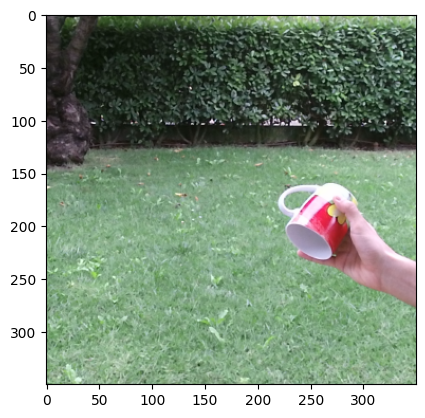

In [ ]:
model = model.eval().to(device)
# Extract the backbone and ROI heads from the model
backbone = model.backbone.body
roi_heads = model.roi_heads.box_predictor

# Load and display the test image
test_img1 = Image.open("/content/drive/MyDrive/AI/test/025.jpg")
test_img1_data = np.asarray(test_img1)
plt.imshow(test_img1_data)
plt.show()

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.CenterCrop(300),
    transforms.Resize(250),
    transforms.ToTensor()
])

transform_norm = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Apply transformations to the input image
transformed_img1 = transform(test_img1)
input_img1 = transform_norm(transformed_img1)
input_img1 = input_img1.unsqueeze(0).to(device)

In [ ]:
# Perform forward pass and get the predicted class and boxes
with torch.no_grad():
    outputs = model(input_img1)
    pred_boxes = outputs[0]['boxes']
    pred_scores = outputs[0]['scores']
    pred_labels = outputs[0]['labels']

    # Print the available keys in outputs[0]
    print(outputs[0].keys())

    # Select the highest scoring prediction
    _, pred_idx = torch.max(pred_scores, dim=0)
    pred_box = pred_boxes[pred_idx]
    pred_label = pred_labels[pred_idx]


dict_keys(['boxes', 'labels', 'scores'])


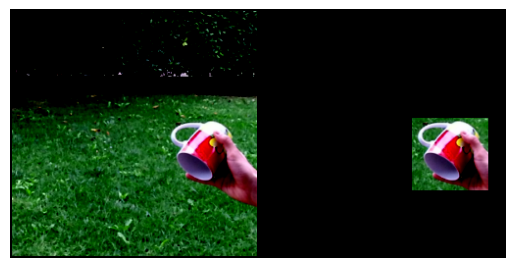

In [ ]:
from torchvision.utils import make_grid, save_image
# Generate a binary mask for the predicted bounding box
masks = torch.zeros((1, 1, input_img1.shape[2], input_img1.shape[3]), dtype=torch.float32, device=device)
masks[:, :, int(pred_box[1]):int(pred_box[3]), int(pred_box[0]):int(pred_box[2])] = 1.0

# Apply the mask to the input image
masked_img = input_img1 * masks

# Convert the masked image to numpy array format
masked_img_np = masked_img.squeeze().cpu().numpy()

# Create a grid of images for visualization
grid_img = make_grid(torch.cat([input_img1, masked_img], dim=0).cpu())

# Convert the grid image to numpy array format
grid_img_np = grid_img.permute(1, 2, 0).numpy()

# Visualize the original image and masked image
plt.imshow(grid_img_np)
plt.axis('off')
plt.show()

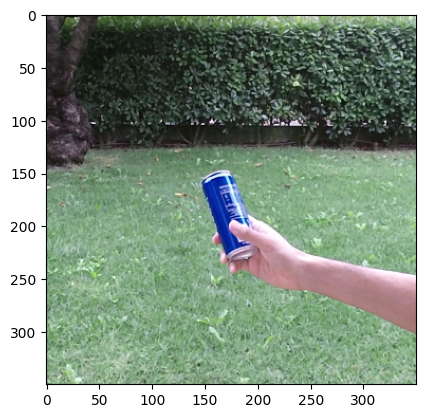

In [ ]:
# Load and display the test image
test_img2 = Image.open("/content/drive/MyDrive/AI/test/225.jpg")
test_img2_data = np.asarray(test_img2)
plt.imshow(test_img2_data)
plt.show()

In [ ]:
# Apply transformations to the input image
transformed_img2 = transform(test_img2)
input_img2 = transform_norm(transformed_img2)
input_img2 = input_img2.unsqueeze(0).to(device)

In [ ]:
# Perform forward pass and get the predicted class and boxes
with torch.no_grad():
    outputs = model(input_img2)
    pred_boxes = outputs[0]['boxes']
    pred_scores = outputs[0]['scores']
    pred_labels = outputs[0]['labels']

    # Print the available keys in outputs[0]
    print(outputs[0].keys())

    # Select the highest scoring prediction
    _, pred_idx = torch.max(pred_scores, dim=0)
    pred_box = pred_boxes[pred_idx]
    pred_label = pred_labels[pred_idx]

dict_keys(['boxes', 'labels', 'scores'])


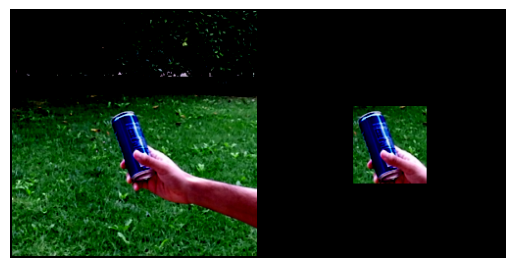

In [ ]:
from torchvision.utils import make_grid, save_image
# Generate a binary mask for the predicted bounding box
masks = torch.zeros((1, 1, input_img2.shape[2], input_img2.shape[3]), dtype=torch.float32, device=device)
masks[:, :, int(pred_box[1]):int(pred_box[3]), int(pred_box[0]):int(pred_box[2])] = 1.0

# Apply the mask to the input image
masked_img = input_img2 * masks

# Convert the masked image to numpy array format
masked_img_np = masked_img.squeeze().cpu().numpy()

# Create a grid of images for visualization
grid_img = make_grid(torch.cat([input_img2, masked_img], dim=0).cpu())

# Convert the grid image to numpy array format
grid_img_np = grid_img.permute(1, 2, 0).numpy()

# Visualize the original image and masked image
plt.imshow(grid_img_np)
plt.axis('off')
plt.show()

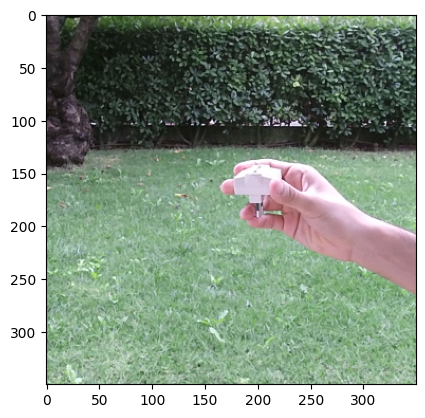

In [ ]:
# Load and display the test image
test_img3 = Image.open("/content/drive/MyDrive/AI/test/525.jpg")
test_img3_data = np.asarray(test_img3)
plt.imshow(test_img3_data)
plt.show()

In [ ]:
# Apply transformations to the input image
transformed_img3 = transform(test_img3)
input_img3 = transform_norm(transformed_img3)
input_img3 = input_img3.unsqueeze(0).to(device)

In [ ]:
# Perform forward pass and get the predicted class and boxes
with torch.no_grad():
    outputs = model(input_img3)
    pred_boxes = outputs[0]['boxes']
    pred_scores = outputs[0]['scores']
    pred_labels = outputs[0]['labels']

    # Print the available keys in outputs[0]
    print(outputs[0].keys())

    # Select the highest scoring prediction
    _, pred_idx = torch.max(pred_scores, dim=0)
    pred_box = pred_boxes[pred_idx]
    pred_label = pred_labels[pred_idx]

dict_keys(['boxes', 'labels', 'scores'])


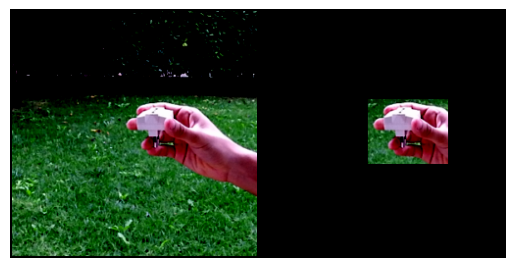

In [ ]:
from torchvision.utils import make_grid, save_image
# Generate a binary mask for the predicted bounding box
masks = torch.zeros((1, 1, input_img3.shape[2], input_img3.shape[3]), dtype=torch.float32, device=device)
masks[:, :, int(pred_box[1]):int(pred_box[3]), int(pred_box[0]):int(pred_box[2])] = 1.0

# Apply the mask to the input image
masked_img = input_img3 * masks

# Convert the masked image to numpy array format
masked_img_np = masked_img.squeeze().cpu().numpy()

# Create a grid of images for visualization
grid_img = make_grid(torch.cat([input_img3, masked_img], dim=0).cpu())

# Convert the grid image to numpy array format
grid_img_np = grid_img.permute(1, 2, 0).numpy()

# Visualize the original image and masked image
plt.imshow(grid_img_np)
plt.axis('off')
plt.show()

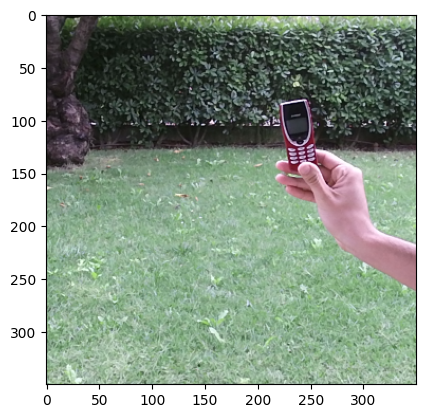

In [ ]:
# Load and display the test image
test_img4 = Image.open("/content/drive/MyDrive/AI/test/725.jpg")
test_img4_data = np.asarray(test_img4)
plt.imshow(test_img4_data)
plt.show()

In [ ]:
# Apply transformations to the input image
transformed_img4 = transform(test_img4)
input_img4 = transform_norm(transformed_img4)
input_img4 = input_img4.unsqueeze(0).to(device)

In [ ]:
# Perform forward pass and get the predicted class and boxes
with torch.no_grad():
    outputs = model(input_img4)
    pred_boxes = outputs[0]['boxes']
    pred_scores = outputs[0]['scores']
    pred_labels = outputs[0]['labels']

    # Print the available keys in outputs[0]
    print(outputs[0].keys())

    # Select the highest scoring prediction
    _, pred_idx = torch.max(pred_scores, dim=0)
    pred_box = pred_boxes[pred_idx]
    pred_label = pred_labels[pred_idx]

dict_keys(['boxes', 'labels', 'scores'])


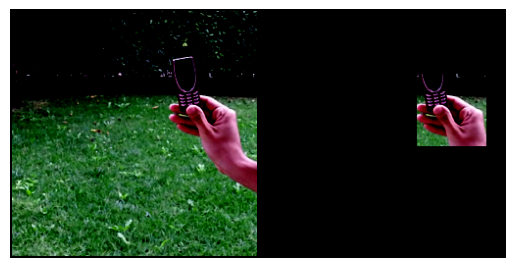

In [ ]:
from torchvision.utils import make_grid, save_image
# Generate a binary mask for the predicted bounding box
masks = torch.zeros((1, 1, input_img4.shape[2], input_img4.shape[3]), dtype=torch.float32, device=device)
masks[:, :, int(pred_box[1]):int(pred_box[3]), int(pred_box[0]):int(pred_box[2])] = 1.0

# Apply the mask to the input image
masked_img = input_img4 * masks

# Convert the masked image to numpy array format
masked_img_np = masked_img.squeeze().cpu().numpy()

# Create a grid of images for visualization
grid_img = make_grid(torch.cat([input_img4, masked_img], dim=0).cpu())

# Convert the grid image to numpy array format
grid_img_np = grid_img.permute(1, 2, 0).numpy()

# Visualize the original image and masked image
plt.imshow(grid_img_np)
plt.axis('off')
plt.show()